In [1]:
import numpy as np
import matplotlib.pyplot as plt
import util

import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Dense, Input
from keras.models import Model, Sequential
import keras.backend as K
from keras.optimizers import Adam, RMSprop

tfd = tfp.distributions
tfpl = tfp.layers

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
Normal = tfp.distributions.Normal
Bernoulii = tfp.distributions.Bernoulli

In [19]:
if __name__ == '__main__' :
    X, Y = util.get_mnist()

Reading in and transforming data...


In [13]:
if __name__ == '__main__' :
    N, D = X.shape
    print(X.shape, Y.shape, sep='\n')

(42000, 784)
(42000,)


In [22]:
class VariationalAutoencoder(Model) :
    def __init__(self, D, hidden_layer_sizes, **kwargs):
        super().__init__(**kwargs)
        self.M = hidden_layer_sizes[-1]
        
        #encoder
        inputs = Input(shape=(D,))
        x = inputs
        for M_out in hidden_layer_sizes[:-1]:
            x = Dense(M_out, activation='relu')(x)
        x = Dense(hidden_layer_sizes[-1] * 2, activation = 'relu') (x)
        x = tfpl.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :self.M], scale=tf.nn.softplus(t[..., self.M:]) + 1e-6),
            name='encoder_output'
        )(x)
        self.encoder = Model(inputs=inputs, outputs=x)

        #decoder
        z = Input(shape=(hidden_layer_sizes[-1],))
        x = z
        for M_out in reversed(hidden_layer_sizes[:-1]):
            x = Dense(M_out, activation='relu')(x)
        x = Dense(D, activation=None)(x)
        self.decoder = Model(inputs=z, outputs=x)

        #self.vae = Model(inputs = encoder.input, outputs = decoder(encoder.output))
        print(self.encoder.summary(), self.decoder.summary())
        
    def compile(self, opt, calc_kl_divergence, calc_expected_log_likelihood, **kwargs):
        super().compile(**kwargs)
        self.opt = opt
        self.calc_kl_divergence = calc_kl_divergence
        self.calc_expected_log_likelihood = calc_expected_log_likelihood
        
    def reparameterize(self, mean, var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * var + mean
    
    def train_step(self, batch, **kwargs):
        ##it takes one batch of data and trains on that batch
        
        X, Y = batch
        with tf.GradientTape() as tape :
            Z_ditribution = self.encoder(X, training = True)
            Z = self.reparameterize(Z_ditribution.loc, Z_ditribution.scale)
            X_hat_logit = self.decoder(Z, training = True)
            #p(x_given_z)
            X_hat_distribution = Bernoulii(logits = X_hat_logit)
            #X_hat_distribution = Normal(loc = X_hat_logit, scale = 1.0)
            
            #prior p(z)
            standard_normal_distribution = Normal(
                loc = tf.zeros(self.M),
                scale= tf.ones(self.M)
            )
            expected_log_likelihood = self.calc_expected_log_likelihood(X_hat_distribution, X)
            kl_divergence = self.calc_kl_divergence(Z_ditribution, standard_normal_distribution)

            elbo = tf.reduce_sum(kl_divergence - expected_log_likelihood)
            
            grad = tape.gradient(elbo, self.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.trainable_variables))
        
        return {'elbo': elbo,}
    
    def test_step(self, batch, **kwargs) :
        X, Y = batch
        X_hat_logit = self.call(X, training = True)
        X_hat_distribution = Bernoulii(logits = X_hat_logit)

        # Call the new model on the input data to get the output of the intermediate layer
        intermediate_output = self.intermediate_model(X, training=False)
        Z_layer_output = intermediate_output
        Z_ditribution = Normal(loc = Z_layer_output[..., :self.M], scale = Z_layer_output[..., self.M:])
        #standard_normal_distribution = Normal(
        #    loc = tf.zeros_like(Z_layer_output[..., :self.M]),
        #    scale= tf.ones_like(Z_layer_output[..., self.M:])
        #)
        standard_normal_distribution = Normal(
            loc = tf.zeros(M),
            scale= tf.ones(M)
        )

        expected_log_likelihood = self.calc_expected_log_likelihood(X_hat_distribution, X)
        kl_divergence = self.calc_kl_divergence(Z_ditribution, standard_normal_distribution)

        elbo = tf.reduce_sum(expected_log_likelihood - kl_divergence)

        return {'elbo': elbo}
    
    def call(self, X, **kwargs) :
        encoded = self.encoder(X, **kwargs)
        decoded = self.decoder(encoded, **kwargs)
        return decoded
    
    def posterior_predictive_sample(self, x, samples = 1) :
        '''
        Posterior predictive sampling : returns a sample from p(x_new | X)

        Parameter
        ---------
        x : (None, D) array
            A D length flattened image array
        
        samples : int
            Number of items to sample from the X_hat_distribution
            Default : 1

        Returns
        -------
        Tuple containing posterior predictive and the mean output image
        (posterior_predictive, posterior_predictive_prob)
        '''
        #returns a sample from p(x_new | X)
        X_hat_logit = self.call(x, training = False)
        X_hat_distribution = Bernoulii(logits = X_hat_logit)
        posterior_predictive = X_hat_distribution.sample(sample_shape=samples)
        posterior_predictive_prob = tf.nn.sigmoid(X_hat_logit) #for the mean output image
        return posterior_predictive, posterior_predictive_prob
    
    def prior_predictive_sample_with_probs(self, samples = 1) :
        '''
        Prior predictive sampling : returns a sample from p(x_new | z), z ~ N(0, 1)

        Parameter
        ---------
        samples : int
            Number of items to sample from the X_hat_distribution
            Default : 1

        Returns
        -------
        Tuple containing prior predictive and the mean output image
        (prior_predictive, prior_predictive_prob)
        '''

        #first draw a sample from Standard Normal of size M, the size of the latent vector
        #sampling from a Z ~ N(0, 1)
        standard_normal_distribution = Normal(
            loc = tf.zeros(self.M),
            scale= tf.ones(self.M)
        )
        std_nrml_sample = standard_normal_distribution.sample(1)  # (1, M)
        X_hat_logit = self.decoder(std_nrml_sample, training = False)  #also called prior_predictive_logit
        X_hat_distribution = Bernoulii(logits = X_hat_logit) #also called prior predictive distribution
        prior_predictive = X_hat_distribution.sample(sample_shape=samples)
        prior_predictive_prob = tf.nn.sigmoid(X_hat_logit) #for the mean output image
        return prior_predictive, prior_predictive_prob
    
    def prior_predictive_sample_with_input(self, z, samples = 1) :
        '''
        Prior predictive sampling : returns a sample from p(x_new | z), given z

        Parameter
        ---------
        Z : (None, M)
            latent vector of size M
        
        samples : int
            Number of items to sample from the X_hat_distribution
            Default : 1

        Returns
        -------
        Tuple containing prior predictive and the mean output image
        (prior_predictive, prior_predictive_prob)
        '''
        
        X_hat_logit = self.decoder(z, training = False)  #also called prior_predictive_logit
        X_hat_distribution = Bernoulii(logits = X_hat_logit) #also called prior predictive distribution
        prior_predictive = X_hat_distribution.sample(sample_shape=samples)
        prior_predictive_prob = tf.nn.sigmoid(X_hat_logit) #for the mean output image
        return prior_predictive, prior_predictive_prob

    
        
def calc_kl_divergence(Z_ditribution, standard_normal_distribution) :
    return tf.reduce_sum(
                tfp.distributions.kl_divergence(Z_ditribution, standard_normal_distribution), 
        axis = 1
    )

def calc_expected_log_likelihood(X_hat_distribution, X) :
    return tf.reduce_sum(
        X_hat_distribution.log_prob(X),
        axis = 1
    )


In [23]:
if __name__ == '__main__' :
    vae = VariationalAutoencoder(D, [200, 100])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 200)               157000    
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 encoder_output (Distributio  ((None, 100),            0         
 nLambda)                     (None, 100))                       
                                                                 
Total params: 197,200
Trainable params: 197,200
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output 

In [9]:
if __name__ == '__main__' :
    X = (X > 0.5).astype(np.float32)
    vae.compile(
        opt = Adam(learning_rate=0.001), 
        calc_kl_divergence = calc_kl_divergence, 
        calc_expected_log_likelihood = calc_expected_log_likelihood, 
        run_eagerly=False
    )
    r = vae.fit(
        X, X, epochs = 100, batch_size = 24,
        workers=8
    )

Epoch 1/100
1750/1750 [==============================] - 6s 3ms/step - elbo: 6924.6642
Epoch 2/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 5543.4902
Epoch 3/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 5250.1520
Epoch 4/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 5112.7289
Epoch 5/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 5017.3279
Epoch 6/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 4953.1346
Epoch 7/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 4904.8164
Epoch 8/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 4863.9019
Epoch 9/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 4826.8584
Epoch 10/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 4796.7089
Epoch 11/100
1750/1750 [==============================] - 5s 3ms/step - elbo: 4769.5107
Epoch 12/100
1750/1750 [=================

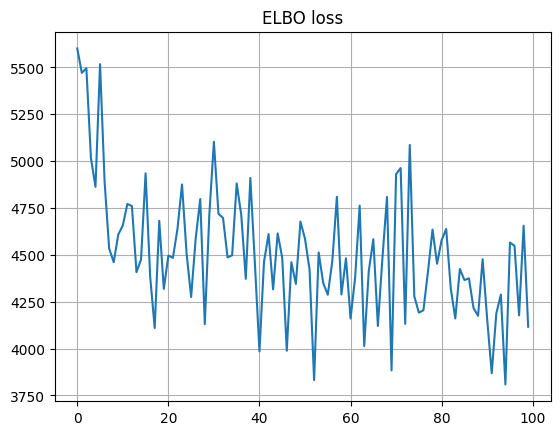

In [10]:
if __name__ == '__main__' :
    plt.plot(r.history['elbo'])
    plt.grid()
    plt.title('ELBO loss')

In [14]:
# Save the model.
#vae.save_weights('vae_tf_v2_weights_2', save_format='tf')

In [20]:
if __name__ == '__main__' :
    vae = VariationalAutoencoder(D, [200, 100])
    vae.load_weights('vae_tf_v2_weights_2')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_9 (Dense)             (None, 200)               157000    
                                                                 
 encoder_output (Distributio  ((None, 100),            0         
 nLambda)                     (None, 100))                       
                                                                 
Total params: 157,000
Trainable params: 157,000
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                    

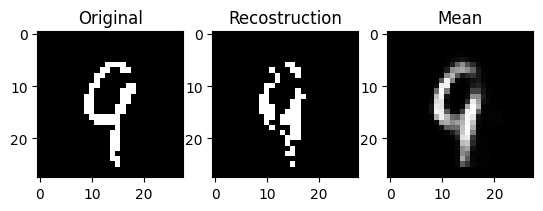

Generate another? y


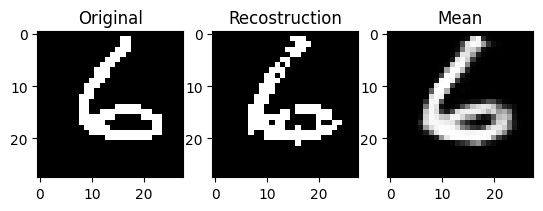

Generate another? y


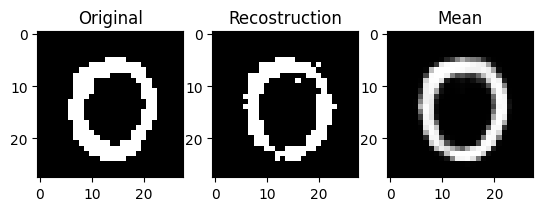

Generate another? y


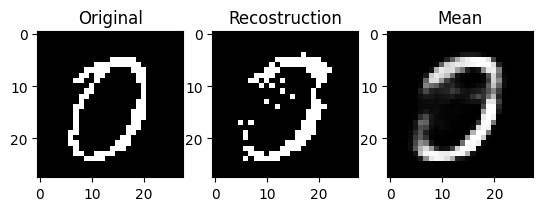

Generate another? y


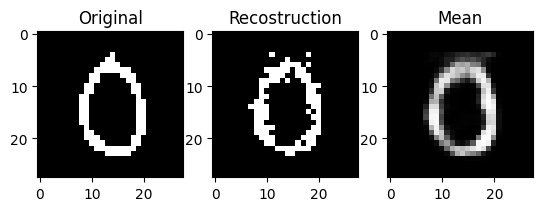

Generate another? y


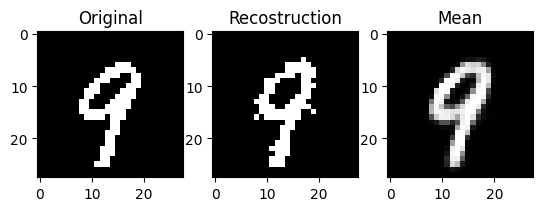

Generate another? y


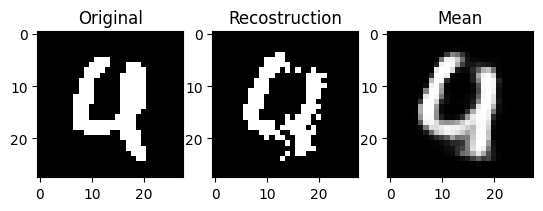

Generate another? y


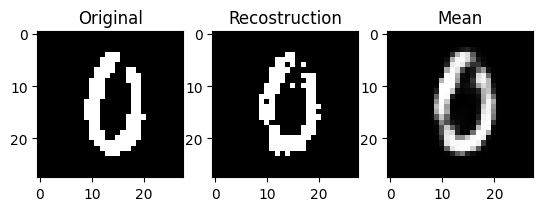

Generate another? y


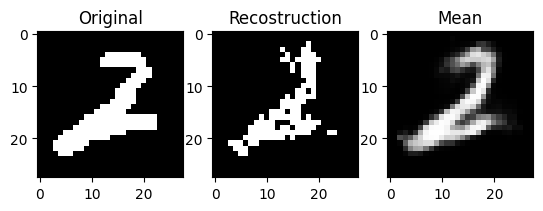

Generate another? n


In [13]:
if __name__ == '__main__' :
    done = False
    while not done :
        i = np.random.choice(len(X))
        x = X[i]
        plt.subplot(1, 3, 1)
        plt.imshow(x.reshape(28, 28), cmap = 'gray')
        plt.title('Original')

        posterior_sample = vae.posterior_predictive_sample(x = x.reshape(1, -1),samples=1)

        plt.subplot(1, 3, 2)
        im = (posterior_sample[0][0]).numpy().reshape(28, 28)
        plt.imshow(im, cmap = 'gray')
        plt.title('Recostruction')

        plt.subplot(1, 3, 3)
        mean = (posterior_sample[1][0]).numpy().reshape(28, 28)
        plt.imshow(mean, cmap = 'gray')
        plt.title('Mean')

        plt.show()


        ans = input('Generate another?')
        if ans and ans[0] in ('n' or 'N') :
            done = True

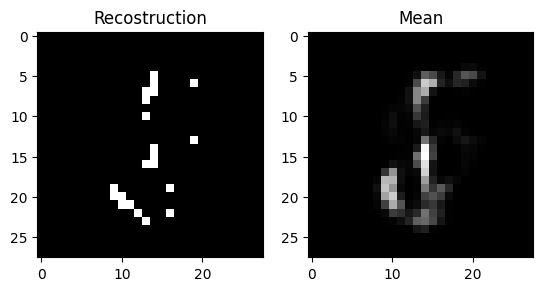

Generate another? y


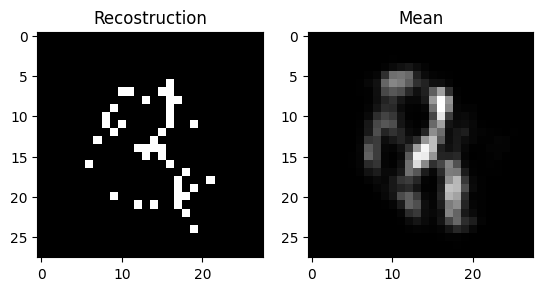

Generate another? y


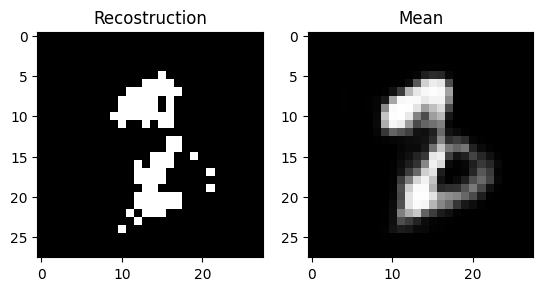

Generate another? y


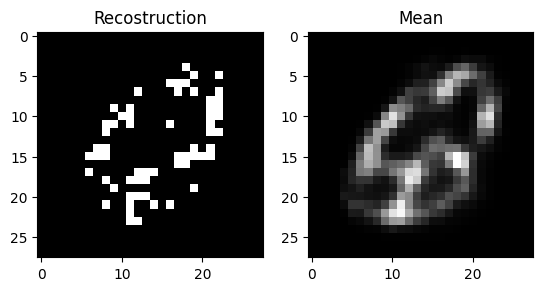

Generate another? y


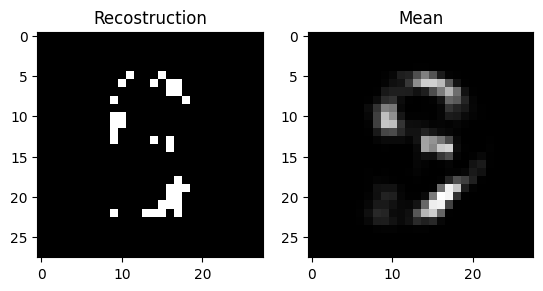

Generate another? y


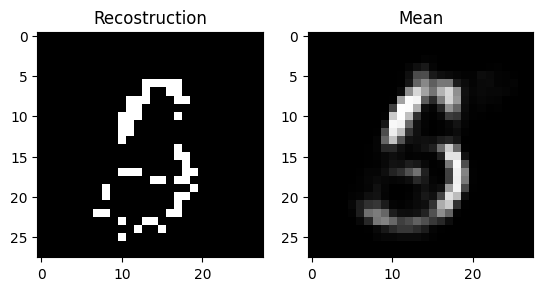

Generate another? y


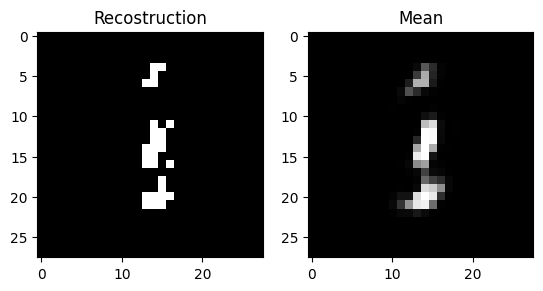

Generate another? y


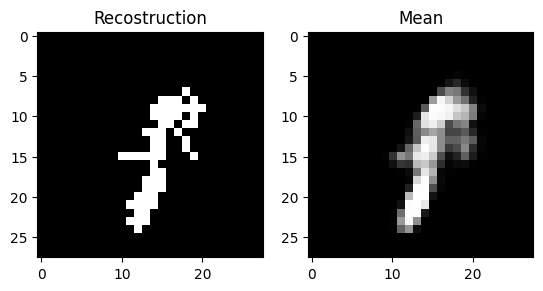

Generate another? y


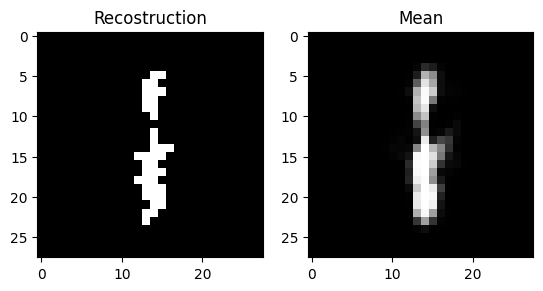

Generate another? y


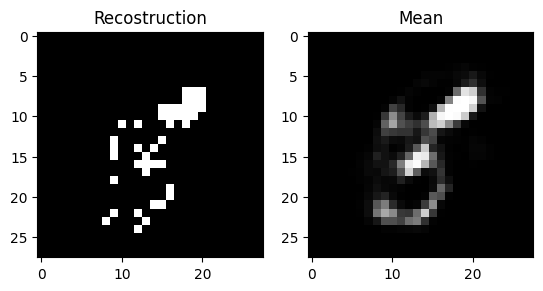

Generate another? y


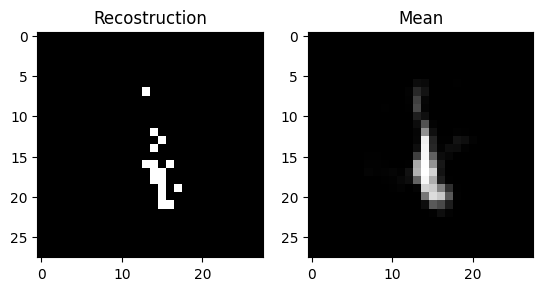

Generate another? n


In [12]:
if __name__ == '__main__' :
    done = False
    while not done :    
        prior_sample = vae.prior_predictive_sample_with_probs(samples=1)

        plt.subplot(1, 2, 1)
        im = (prior_sample[0][0]).numpy().reshape(28, 28)
        plt.imshow(im, cmap = 'gray')
        plt.title('Recostruction')

        plt.subplot(1, 2, 2)
        mean = (prior_sample[1][0]).numpy().reshape(28, 28)
        plt.imshow(mean, cmap = 'gray')
        plt.title('Mean')

        plt.show()


        ans = input('Generate another?')
        if ans and ans[0] in ('n' or 'N') :
            done = True